In [1]:
# What drives happiness?
# What are the factors that influence suicide rate?

# import dependencies
from config import census_key
import requests
from pprint import pprint
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math

In [2]:
# Get census data using api

vars_full = {
    'B19001_001E': 'Household income',
#     'B19083_001E': 'GINI INDEX OF INCOME INEQUALITY',
#     'B19202_001E': 'MEDIAN NONFAMILY HOUSEHOLD INCOME',
    'B15001_044E': 'Estimate!!Total!!Female!!18 to 24 years',
    'B15001_003E': 'Estimate!!Total!!Male!!18 to 24 years',
    'B15001_046E': 'Estimate!!Total!!Female!!18 to 24 years!!9th to 12th grade no diploma',
    'B15001_005E': 'Estimate!!Total!!Male!!18 to 24 years!!9th to 12th grade no diploma',
#
    'B23001_048E': 'Estimate!!Total!!Male!!45 to 54 years!!In labor force!!Civilian',
    'B23001_050E': 'Estimate!!Total!!Male!!45 to 54 years!!In labor force!!Civilian!!Unemployed',
#
    'B27001_018E': 'Estimate!!Total!!Male!!45 to 54 years',
    'B27001_020E': 'Estimate!!Total!!Male!!45 to 54 years!!No health insurance coverage',
#
    'B17001A_001E': 'Estimate!!Total, whites',
    'B17001A_002E': 'Estimate!!Total!!Income in the past 12 months below poverty level, whites',
#
    'B21001_004E': 'Estimate!!Total!!Male',
    'B21001_005E': 'Estimate!!Total!!Male!!Veteran',
#
    'B01003_001E': 'Total population'
}
vars = list(vars_full.keys())

In [3]:
url_start = 'https://api.census.gov/data/2017/acs/acs5?get='
url_mid = 'NAME,' + ','.join(vars)
url_end = '&for=county:*&key='
url = url_start + url_mid + url_end + census_key
response = requests.get(url)

In [4]:
df = pd.DataFrame(response.json()[1:], columns=response.json()[0])
county_code = df['state'] + df['county']
county_code = [code.lstrip('0') for code in county_code]
df['County Code'] = county_code
df = df.set_index('County Code')

# # Find Yolo County. Codes here: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
# df.loc[(df['state'] == '06') & (df['county'] == '113')]
# df_full[df_full['NAME'].str.match('Yolo')]

In [5]:
# Import suicide rates csv
path_csv = 'suicide_rates.csv'
df_grim = pd.read_csv(path_csv)
# convert county code column to string
df_grim['County Code'] = df_grim['County Code'].astype(str)
df_grim = df_grim.set_index('County Code')
# Calculate suicide rate per 100k
df_grim['Suicide Rate'] = df_grim['Deaths'] / df_grim['Population'] *100000 

In [6]:
# Import county land area csv
path_csv = 'county_areas.csv'
df_areas = pd.read_csv(path_csv)
df_areas['County Code'] = df_areas['County Code'].astype(str)
df_areas = df_areas.set_index('County Code')

In [17]:
# Get median income data for 2017
# from https://api.census.gov/data/2017/acs/acs5/profile/variables.html
# 'DP03_0062E' #Estimate!!INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)
url_start = 'https://api.census.gov/data/2017/acs/acs5/profile?get='
url_mid = 'NAME,' + 'DP03_0062E' #median income
url_end = '&for=county:*&key='
url = url_start + url_mid + url_end + census_key
response = requests.get(url)
# store in dataframe
df_income_2017 = pd.DataFrame(response.json()[1:], columns=response.json()[0])
county_code = df_income_2017['state'] + df_income_2017['county']
county_code = [code.lstrip('0') for code in county_code]
df_income_2017['County Code'] = county_code
df_income_2017 = df_income_2017.set_index('County Code')
# Get median income data for 2009
# downloaded from https://factfinder.census.gov/faces/nav/jsf/pages/download_center.xhtml
path_csv = 'acs5_2009_median_income.csv'
df_income_2009 = pd.read_csv(path_csv, encoding = "ISO-8859-1")
df_income_2009['County Code'] = df_income_2009['County Code'].astype(str)
df_income_2009 = df_income_2009.set_index('County Code')
# Join 2009, 2017 Median Income tables
df_incomes = df_income_2017.join(df_income_2009, on='County Code', how='inner')
df_incomes = df_incomes[['DP03_0062E', 'Median household income (dollars)']]
df_incomes = df_incomes.rename(columns = {'DP03_0062E': 'income_2017', 'Median household income (dollars)': 'income_2009'})
# convert to float
df_incomes['income_2017'] = [float(i) for i in df_incomes['income_2017']]
df_incomes['income_2009'] = [float(i) for i in df_incomes['income_2009']]
df_incomes.head()

,income_2017,income_2009
County Code,,
1107,36220.0,27150.0
1119,21663.0,20994.0
1073,49321.0,44718.0
1023,32122.0,30749.0
1059,39501.0,33380.0


In [18]:
# Join census, area, and suicide dataframes
df_full = df.join(df_grim, on='County Code', how='inner') \
            .join(df_areas, on='County Code', how='inner') \
            .join(df_incomes, on='County Code', how='inner')

# convert numerical columns into float
for thisVar in vars:
    df_full[thisVar] = [float(i) for i in df_full[thisVar]]
    
# calculate population density
df_full['Population Density'] = df_full['B01003_001E'] / df_full['ALAND_SQMI']
    
# Order by highest suicide rate
df_full = df_full.sort_values(by='Suicide Rate', ascending=False)

df_full.head()

,NAME,B19001_001E,B15001_044E,B15001_003E,B15001_046E,B15001_005E,B23001_048E,B23001_050E,B27001_018E,B27001_020E,...,state,county,County,Deaths,Population,Suicide Rate,ALAND_SQMI,income_2017,income_2009,Population Density
County Code,,,,,,,,,,,,,,,,,,,,,
2180,"Nome Census Area, Alaska",2897.0,472.0,552.0,55.0,119.0,482.0,83.0,608.0,241.0,...,02,180,"Nome Census Area, AK",34,49393,68.835665,22970.019,53821.0,55766.0,0.429647
38085,"Sioux County, North Dakota",1114.0,223.0,228.0,77.0,90.0,148.0,21.0,258.0,90.0,...,38,085,"Sioux County, ND",14,22067,63.443150,1094.052,40795.0,29858.0,4.040027
2290,"Yukon-Koyukuk Census Area, Alaska",1959.0,219.0,262.0,51.0,50.0,273.0,55.0,343.0,175.0,...,02,290,"Yukon-Koyukuk Census Area, AK",16,27666,57.832719,145575.515,37819.0,33716.0,0.037458
8027,"Custer County, Colorado",2093.0,112.0,153.0,13.0,18.0,156.0,46.0,211.0,74.0,...,08,027,"Custer County, CO",13,22567,57.606239,738.626,41330.0,44713.0,6.099162
46031,"Corson County, South Dakota",1239.0,203.0,189.0,83.0,84.0,192.0,39.0,254.0,83.0,...,46,031,"Corson County, SD",12,20929,57.336710,2469.694,32260.0,29750.0,1.691303


Text(0, 0.5, 'Count')

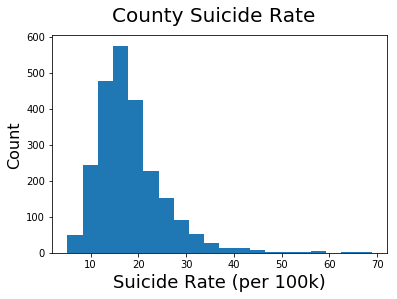

In [9]:
n_bins = 20
fig = plt.figure()
plt.hist(df_full['Suicide Rate'], bins=n_bins)
fig.suptitle('County Suicide Rate', fontsize=20)
plt.xlabel('Suicide Rate (per 100k)', fontsize=18)
plt.ylabel('Count', fontsize=16)

Slope = 33.988709728517655
r-squared = 0.08624282158322402
p-value = 3.357344563211467e-48


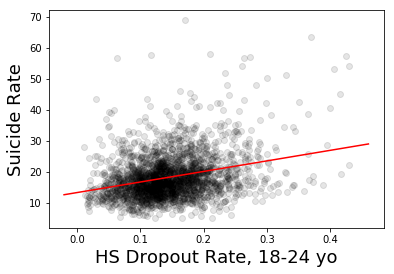

In [10]:
# Define x and y
x = (df_full['B15001_005E'] + df_full['B15001_046E']) / (df_full['B15001_003E'] + df_full['B15001_044E'])
y = df_full['Suicide Rate']

# Plot
fig = plt.scatter(x, y, c='black', alpha=0.1)
axes = plt.gca()
# axes.set_xlim([0,500000])
plt.ylabel('Suicide Rate', fontsize=18)
plt.xlabel('HS Dropout Rate, 18-24 yo', fontsize=18)


# Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# Plot a line from slope and intercept
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '-', color="red")
print(f"Slope = {slope}")
print(f"r-squared = {r_value**2}")
print(f"p-value = {p_value}")
# plt.savefig("happySauce_fig01.png")

Slope = 48.204113919417445
r-squared = 0.10843890927949432
p-value = 7.492949003445968e-61


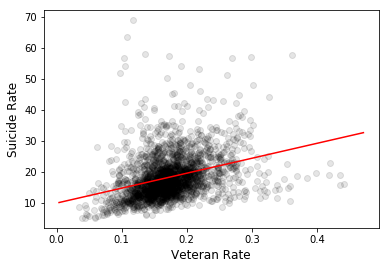

In [11]:
# Define x and y
x = df_full['B21001_005E'] / df_full['B21001_004E']
y = df_full['Suicide Rate']

# Plot
fig = plt.scatter(x, y, c='black', alpha=0.1)
axes = plt.gca()
# axes.set_xlim([0,500000])
plt.ylabel('Suicide Rate', fontsize=12)
plt.xlabel('Veteran Rate', fontsize=12)


# Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# Plot a line from slope and intercept
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '-', color="red")
print(f"Slope = {slope}")
print(f"r-squared = {r_value**2}")
print(f"p-value = {p_value}")
# plt.savefig("happySauce_fig01.png")

Slope = -6.108286810291233
r-squared = 0.3272379287351101
p-value = 2.1587276126272736e-205


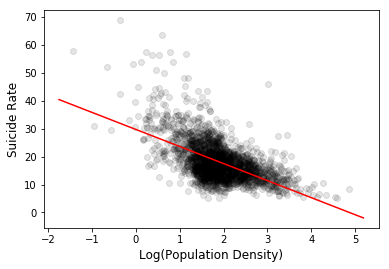

In [12]:
# Define x and y
x = df_full['Population Density']
y = df_full['Suicide Rate']
x = [math.log(i, 10) for i in x]

# Plot
fig = plt.scatter(x, y, c='black', alpha=0.1)
axes = plt.gca()
# axes.set_xlim([0,2000])
plt.ylabel('Suicide Rate', fontsize=12)
plt.xlabel('Log(Population Density)', fontsize=12)

# Most dense counties
# df_full.loc[df_full['Population Density'] > 20000]

# Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# Plot a line from slope and intercept
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '-', color="red")
print(f"Slope = {slope}")
print(f"r-squared = {r_value**2}")
print(f"p-value = {p_value}")
# plt.savefig("happySauce_fig01.png")

Slope = -0.000137693374616869
r-squared = 0.0693249836137168
p-value = 9.424633846014432e-39


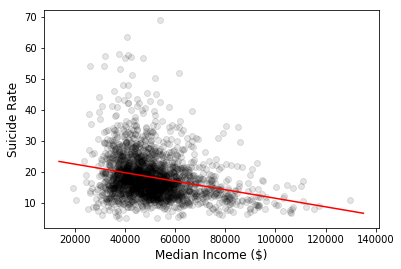

In [19]:
# Define x and y
x = df_full['income_2017']
y = df_full['Suicide Rate']

# Plot
fig = plt.scatter(x, y, c='black', alpha=0.1)
axes = plt.gca()
# axes.set_xlim([0,2000])
plt.ylabel('Suicide Rate', fontsize=12)
plt.xlabel('Median Income ($)', fontsize=12)

# Most dense counties
# df_full.loc[df_full['Population Density'] > 20000]

# Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# Plot a line from slope and intercept
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '-', color="red")
print(f"Slope = {slope}")
print(f"r-squared = {r_value**2}")
print(f"p-value = {p_value}")
# plt.savefig("happySauce_fig01.png")

Slope = -4.10198851434465e-05
r-squared = 0.0004746009997923695
p-value = 0.28989974036594707


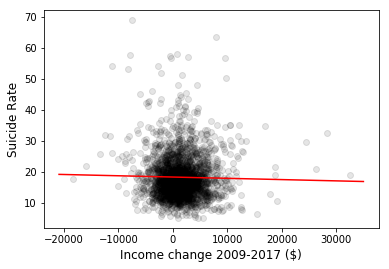

In [22]:
# Define x and y
x = df_full['income_2017'] - (df_full['income_2009']*1.1) # adjusted for inflation
y = df_full['Suicide Rate']

# Plot
fig = plt.scatter(x, y, c='black', alpha=0.1)
axes = plt.gca()
# axes.set_xlim([0,2000])
plt.ylabel('Suicide Rate', fontsize=12)
plt.xlabel('Income change 2009-2017 ($)', fontsize=12)

# Most dense counties
# df_full.loc[df_full['Population Density'] > 20000]

# Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# Plot a line from slope and intercept
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '-', color="red")
print(f"Slope = {slope}")
print(f"r-squared = {r_value**2}")
print(f"p-value = {p_value}")
# plt.savefig("happySauce_fig01.png")

Text(0, 0.5, 'Count')

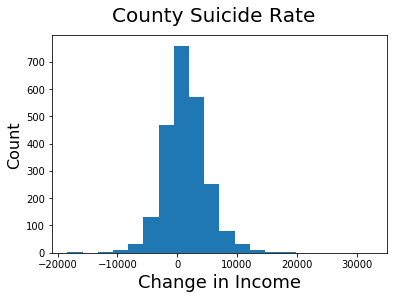

In [24]:
n_bins = 20
fig = plt.figure()
plt.hist(df_full['income_2017'] - (df_full['income_2009']*1.1), bins=n_bins)
fig.suptitle('County Suicide Rate', fontsize=20)
plt.xlabel('Change in Income', fontsize=18)
plt.ylabel('Count', fontsize=16)